**References used for the dataset**
1. https://www.cs.toronto.edu/~kriz/cifar.html
2. https://keras.io/api/datasets/cifar10/

**References used for the network architecture**
1. https://arxiv.org/abs/1704.06904
2. https://github.com/tengshaofeng/ResidualAttentionNetwork-pytorch/blob/master/Residual-Attention-Network/model/attention_module.py
3. https://github.com/Piyushdharkar/Residual-Attention-Aware-Network
4. https://github.com/deontaepharr/Residual-Attention-Network

**References used for keras functions**
1. https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/
2. https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [1]:
import numpy as np
import time
import tensorflow as tf
from matplotlib import pyplot as plt

**Load the CIFAR-10 Dataset**

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print("\n x_train.shape: ", x_train.shape)
print("\n y_train.shape: ", y_train.shape)

print("\n x_test.shape: ", x_test.shape)
print("\n y_test.shape: ", y_test.shape)


 x_train.shape:  (50000, 32, 32, 3)

 y_train.shape:  (50000, 1)

 x_test.shape:  (10000, 32, 32, 3)

 y_test.shape:  (10000, 1)


**Visualize the dataset**

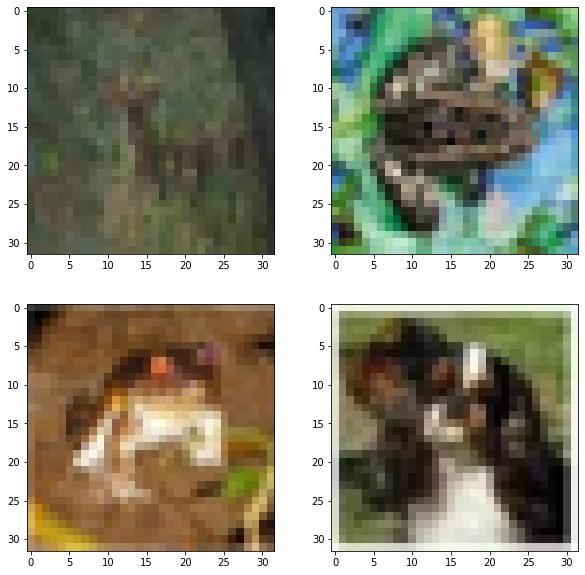

In [4]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 10))

axes[0, 0].imshow(x_train[10])
axes[0, 1].imshow(x_train[200])
axes[1, 0].imshow(x_train[0])
axes[1, 1].imshow(x_train[500])

In [5]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)

**Divide the data into train, test and validation**

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
np.random.seed(0)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8)

print("\n x_train.shape: ", x_train.shape)
print("\n y_train.shape: ", y_train.shape)

print("\n x_val.shape: ", x_val.shape)
print("\n y_val.shape: ", y_val.shape)

print("\n x_test.shape: ", x_test.shape)
print("\n y_test.shape: ", y_test.shape)


 x_train.shape:  (40000, 32, 32, 3)

 y_train.shape:  (40000, 10)

 x_val.shape:  (10000, 32, 32, 3)

 y_val.shape:  (10000, 10)

 x_test.shape:  (10000, 32, 32, 3)

 y_test.shape:  (10000, 10)


**Creating Residual Block**

In [8]:
from tensorflow.keras import activations

In [9]:
def create_residual_block(val_in, filter_in, filter_out):
    '''
    @params val_in : Input shape
    @params filter_in : Input filter
    @params filter_out : Output filter
    @output : Tensor created after residual block
    '''
    
    # Repeat BN=>ReLU=>Conv2D pattern three times
    
    x = tf.keras.layers.BatchNormalization()(val_in)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_in, kernel_size = 1, padding = 'same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 3, padding = 'same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 1, padding = 'same')(x)
    
    val_in = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 1, padding = 'same')(val_in)
    
    x = tf.keras.layers.Add()([val_in, x])
    
    return x

**Creating Attention Block**

The attention Module consists of mask branch and trunk branch. The trunk branch performs feature selection (using the residual blocks) and the mask branch learns the mask to be applied from downsampling and upsampling. The output of the attention block is (1+M(x)).T(x), where M(x) is the mask and T(x) is the output of the trunk branch (pre-processing).

In [10]:
def create_attention_block(val_in, filter_in, filter_out, p = 1, t = 2, r = 1):
    '''
    @params val_in : Input shape
    @params filter_in : Input filter
    @params filter_out : Output filter
    @params p : Number of pre-processing residual units before splitting into trunk and mask branch (is also a hyperparameter)
    @params t : Number of residual units in trunk branch (is also a hyperparameter)
    @params r : Number of residual units between adjacent pooling layer in the mask branch (is also a hyperparameter)
    @output: Tensor created after attention block
    '''
    
    # Creating residual blocks for pre-processing residual units
    for units in range(p):
        val_in = create_residual_block(val_in, filter_in, filter_out)
     
    val_out_trunk = val_in
    
    # Feature Processing for the trunk branch. Input to the trunk branch is the output of the pre-processing residual blocks
    for units in range(t):
        val_out_trunk = create_residual_block(val_out_trunk, filter_in, filter_out)
        
    # 1. Downsample using MaxPool2D
    # 2. 'r' represents the number of residual units between two max pool layers in the mask branch. Implemented using for loop
    # 3. Add skip connection
    # 4. Upsample using UpSampling2D
    
    
    # Down Sampling One
    soft_mask_output = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(val_in)
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    
    # Adding Skip Connection
    skip_connection = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    # Down Sampling Two
    soft_mask_output = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(soft_mask_output)
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    # Up Sampling One
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
        soft_mask_output = tf.keras.layers.UpSampling2D(size=2)(soft_mask_output)
        soft_mask_output = tf.keras.layers.Add()([soft_mask_output, skip_connection])
        
    # Up Sampling Two
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    soft_mask_output = tf.keras.layers.UpSampling2D(size=2)(soft_mask_output)
    
    soft_mask_output = tf.keras.layers.Conv2D(filter_in, kernel_size=1)(soft_mask_output)
    soft_mask_output = tf.keras.layers.Conv2D(filter_in, kernel_size=1)(soft_mask_output)
    soft_mask_output = tf.keras.layers.Activation(activation='sigmoid')(soft_mask_output)
    
    # Output is (1 + M(x))*T(x)
    output = tf.keras.layers.Lambda(lambda x: x + 1)(soft_mask_output)
    output = tf.keras.layers.Multiply()([output, val_out_trunk]) 
    
    for i in range(p):
        output = create_residual_block(output, filter_in, filter_out)

    return output

**Creating the Model**

In [11]:
def create_model(size, classes):
    '''
    @params size : Input tensor siz
    @params classes : Number of output classes
    @output : Returns the model created by attention modules
    '''
    val_in = tf.keras.layers.Input(shape=size)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same')(val_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=1, padding='same')(x)

    x = create_residual_block(val_in=x, filter_in=32, filter_out=128)
    x = create_attention_block(val_in=x, filter_in=32, filter_out=32)

    x = create_residual_block(val_in=x, filter_in=64, filter_out=128)
    x = create_attention_block(val_in=x, filter_in=64, filter_out=64)

    x = create_residual_block(val_in=x, filter_in=128, filter_out=256)
    x = create_attention_block(val_in=x, filter_in=128, filter_out=128)

    x = create_residual_block(val_in=x, filter_in=128, filter_out=256)
    x = create_residual_block(val_in=x, filter_in=256, filter_out=256)
    x = create_residual_block(val_in=x, filter_in=256, filter_out=256)

    x = tf.keras.layers.AveragePooling2D(pool_size=4)(x)
    x = tf.keras.layers.Flatten()(x)

    output = tf.keras.layers.Dense(classes, activation='softmax')(x)


    return tf.keras.models.Model(val_in, output)

**Initialize the Model**

In [12]:
model_cifar_10_batch_size_32 = create_model(x_train.shape[1:], 10)

model_cifar_10_batch_size_32.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Viusalize the Model**

To visualize the model, we use the Netron Package

1. Install netron using the pip command below

2. Download Netron package from here : https://github.com/lutzroeder/netron/releases/tag/v5.4.3

3. Save the model using the command below

4. Open and visualize the saved model with Netron

In [13]:
pip install netron

Note: you may need to restart the kernel to use updated packages.


**Train the Model**

In [13]:
tic = time.time()
history_cifar_10_batch_size_32 = model_cifar_10_batch_size_32.fit(x_train, y_train, batch_size = 32, epochs = 25, 
                                                                          validation_data = (x_val, y_val))
toc = time.time()

Epoch 1/25
1250/1250 [==============================] - 359s 268ms/step - loss: 3.7462 - accuracy: 0.3486 - val_loss: 1.5134 - val_accuracy: 0.4510
Epoch 2/25
1250/1250 [==============================] - 331s 265ms/step - loss: 1.2887 - accuracy: 0.5515 - val_loss: 1.6104 - val_accuracy: 0.5019
Epoch 3/25
1250/1250 [==============================] - 330s 264ms/step - loss: 1.1583 - accuracy: 0.6014 - val_loss: 1.1309 - val_accuracy: 0.6044
Epoch 4/25
1250/1250 [==============================] - 330s 264ms/step - loss: 1.0657 - accuracy: 0.6274 - val_loss: 1.4224 - val_accuracy: 0.5220
Epoch 5/25
1250/1250 [==============================] - 329s 263ms/step - loss: 1.0156 - accuracy: 0.6428 - val_loss: 1.0389 - val_accuracy: 0.6317
Epoch 6/25
1250/1250 [==============================] - 329s 263ms/step - loss: 0.9514 - accuracy: 0.6665 - val_loss: 1.1604 - val_accuracy: 0.5969
Epoch 7/25
1250/1250 [==============================] - 328s 262ms/step - loss: 0.9421 - accuracy: 0.6750 - val_

In [14]:
model_cifar_10_batch_size_32.save('model_cifar_10_batch_size_32.h5')

In [15]:
print("\n Time to train CIFAR-10 with batch size 32: ", (toc - tic)/60, "mins")


 Time to train CIFAR-10 with batch size 32:  135.8668930133184 mins


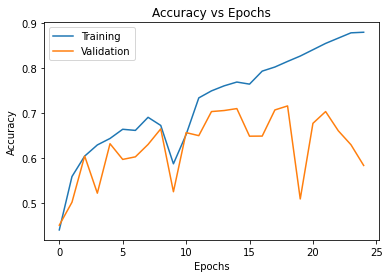

In [17]:
plt.plot(history_cifar_10_batch_size_32.history['accuracy'], label = 'Training')
plt.plot(history_cifar_10_batch_size_32.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs Epochs")
plt.legend(loc = 'upper left')

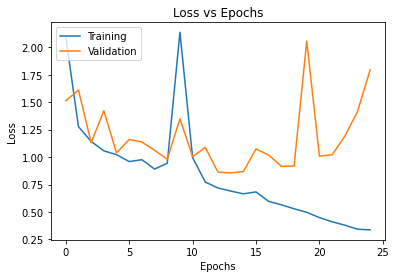

In [18]:
plt.plot(history_cifar_10_batch_size_32.history['loss'], label = 'Training')
plt.plot(history_cifar_10_batch_size_32.history['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs Epochs")
plt.legend(loc = 'upper left')